# Projet 4 : Anticipez les besoins en consommation électrique de bâtiments
## Notebook de modélisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

from xgboost import XGBRegressor

import pickle
import glob

# 1. Chargement des données

In [2]:
data = pd.read_csv('data_cleaned')

In [3]:
data.head()

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,LargestPropertyUseType,SecondLargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge
0,Multifamily LR (1-4),Residential,7.0,DOWNTOWN,47.609736,-122.340384,Residential,Retail,1.0,4.0,48383.0,0.0,48383.0,38172.0,10211.0,3379678.0,112.06,115.0
1,Multifamily LR (1-4),Residential,1.0,DELRIDGE,47.544238,-122.376171,Residential,Not Used,1.0,4.0,52134.0,0.0,52134.0,52134.0,0.0,1369895.0,8.45,8.0
2,NonResidential,Office,7.0,DOWNTOWN,47.606799,-122.337100,Office,Not Used,1.0,6.0,98370.0,25920.0,72450.0,98370.0,0.0,6541579.0,47.24,109.0
3,NonResidential,Office,7.0,LAKE UNION,47.621476,-122.343050,Office,Parking,1.0,4.0,193788.0,37854.0,155934.0,138672.0,47539.0,16463978.0,116.84,68.0
4,NonResidential,Office,2.0,GREATER DUWAMISH,47.570897,-122.297412,Office,Parking,1.0,3.0,76598.0,21410.0,55188.0,55188.0,21410.0,4617864.0,134.69,7.0


In [4]:
data.isna().sum()

BuildingType                       0
PrimaryPropertyType                0
CouncilDistrictCode                0
Neighborhood                       0
Latitude                           0
Longitude                          0
LargestPropertyUseType             0
SecondLargestPropertyUseType       0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
SiteEnergyUseWN(kBtu)              0
TotalGHGEmissions                  0
BuildingAge                        0
dtype: int64

# 2. Préparation des données 

## 2.1. Passage au log des variables cibles

In [5]:
log_energy = np.log(data['SiteEnergyUseWN(kBtu)'])

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


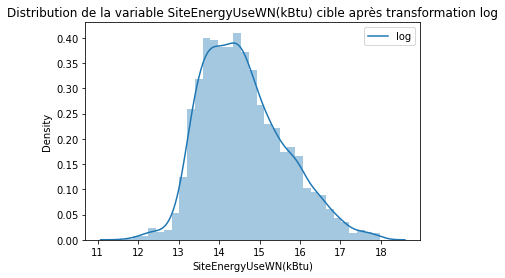

In [6]:
plt.title('Distribution de la variable SiteEnergyUseWN(kBtu) cible après transformation log')
sns.distplot(log_energy)
ax = plt.gca()
ax.legend(['log'])
plt.show()

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


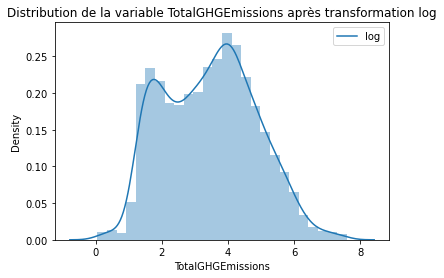

In [7]:
log_emissions = np.log(data['TotalGHGEmissions'])
plt.title('Distribution de la variable TotalGHGEmissions après transformation log')
sns.distplot(log_emissions)
ax = plt.gca()
ax.legend(['log'])
plt.show()

In [8]:
# création de colonnes cibles (avec passage au log)
data['Log-SiteEnergyUseWN(kBtu)']= np.log(data['SiteEnergyUseWN(kBtu)'])
data['log-TotalGHGEmissions']=np.log(data['TotalGHGEmissions'])

In [9]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'BuildingAge',
       'Log-SiteEnergyUseWN(kBtu)', 'log-TotalGHGEmissions'],
      dtype='object')

### 2.2 Définition des X et y

In [10]:
y = data.copy()[{'Log-SiteEnergyUseWN(kBtu)','SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'}]

X = data.copy().drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 
                      'Log-SiteEnergyUseWN(kBtu)','log-TotalGHGEmissions'], axis=1)

### 2.3. Standard scaler des variables numériques

In [11]:
numerical_variables = X.select_dtypes(['float64']).columns
numerical_variables

Index(['CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'BuildingAge'],
      dtype='object')

In [12]:
def standard_scaler(df):
    ss = StandardScaler()
    numerical_columns = df.select_dtypes(['float64']).columns
    for col in numerical_columns:
        df[numerical_columns] = ss.fit_transform(df[numerical_columns])
    return df
    
    

In [13]:
standard_scaler(X)

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,LargestPropertyUseType,SecondLargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,BuildingAge
0,Multifamily LR (1-4),Residential,1.212985,DOWNTOWN,-0.303974,-0.198485,Residential,Retail,-0.069128,-0.098826,-0.324093,-0.333214,-0.280343,-0.357211,-0.035132,2.032469
1,Multifamily LR (1-4),Residential,-1.619262,DELRIDGE,-1.667002,-1.514531,Residential,Not Used,-0.069128,-0.098826,-0.284103,-0.333214,-0.233852,-0.173274,-0.438993,-1.195144
2,NonResidential,Office,1.212985,DOWNTOWN,-0.365093,-0.077714,Office,Not Used,-0.069128,0.401893,0.208820,0.776735,0.017954,0.435847,-0.438993,1.851481
3,NonResidential,Office,1.212985,LAKE UNION,-0.059662,-0.296526,Office,Parking,-0.069128,-0.098826,1.226073,1.287774,1.052694,0.966792,1.441248,0.614732
4,NonResidential,Office,-1.147221,GREATER DUWAMISH,-1.112236,1.381808,Office,Parking,-0.069128,-0.349186,-0.023292,0.583607,-0.195999,-0.133040,0.407806,-1.225309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,Multifamily MR (5-9),Residential,-0.203138,NORTHEAST,0.818207,0.753396,Residential,Not Used,-0.069128,0.652252,-0.159465,-0.125527,-0.149061,0.078445,-0.438993,-1.406296
3226,Multifamily MR (5-9),Residential,-0.203138,NORTHEAST,0.654013,0.660724,Residential,Not Used,-0.069128,0.652252,2.624927,-0.333214,3.148177,3.421506,-0.438993,-1.406296
3227,Multifamily MR (5-9),Residential,-0.675179,EAST,-0.467250,0.484206,Residential,Parking,-0.069128,0.401893,0.077423,0.048245,0.076047,0.172219,-0.117597,-1.406296
3228,NonResidential,Mixed Use Property,1.212985,LAKE UNION,0.013053,-0.141330,Health,Office,-0.069128,0.401893,2.841239,3.307865,2.345784,1.136093,3.773168,-1.406296


### 2.4. Label Encoding des variables catégorielles

In [14]:
def Label_Encoder(df):
    
    labelEnc=preprocessing.LabelEncoder()
    catagorical_columns = df.select_dtypes(['category','object']).columns.tolist()
    
    for col in catagorical_columns:
        df[col]=labelEnc.fit_transform(df[col])
        
    return df

In [15]:
Label_Encoder(X)

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,LargestPropertyUseType,SecondLargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,BuildingAge
0,2,9,1.212985,3,-0.303974,-0.198485,8,10,-0.069128,-0.098826,-0.324093,-0.333214,-0.280343,-0.357211,-0.035132,2.032469
1,2,9,-1.619262,2,-1.667002,-1.514531,8,5,-0.069128,-0.098826,-0.284103,-0.333214,-0.233852,-0.173274,-0.438993,-1.195144
2,4,7,1.212985,3,-0.365093,-0.077714,5,5,-0.069128,0.401893,0.208820,0.776735,0.017954,0.435847,-0.438993,1.851481
3,4,7,1.212985,6,-0.059662,-0.296526,5,8,-0.069128,-0.098826,1.226073,1.287774,1.052694,0.966792,1.441248,0.614732
4,4,7,-1.147221,5,-1.112236,1.381808,5,8,-0.069128,-0.349186,-0.023292,0.583607,-0.195999,-0.133040,0.407806,-1.225309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,3,9,-0.203138,9,0.818207,0.753396,8,5,-0.069128,0.652252,-0.159465,-0.125527,-0.149061,0.078445,-0.438993,-1.406296
3226,3,9,-0.203138,9,0.654013,0.660724,8,5,-0.069128,0.652252,2.624927,-0.333214,3.148177,3.421506,-0.438993,-1.406296
3227,3,9,-0.675179,4,-0.467250,0.484206,8,8,-0.069128,0.401893,0.077423,0.048245,0.076047,0.172219,-0.117597,-1.406296
3228,4,6,1.212985,6,0.013053,-0.141330,3,6,-0.069128,0.401893,2.841239,3.307865,2.345784,1.136093,3.773168,-1.406296


In [16]:
X.shape

(3230, 16)

In [17]:
y.shape

(3230, 3)

In [18]:
X.isna().sum()

BuildingType                       0
PrimaryPropertyType                0
CouncilDistrictCode                0
Neighborhood                       0
Latitude                           0
Longitude                          0
LargestPropertyUseType             0
SecondLargestPropertyUseType       0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
BuildingAge                        0
dtype: int64

### 2.5. Création des jeux de données d'entraitement et de test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                         y['Log-SiteEnergyUseWN(kBtu)'],  
                                         test_size = 0.3, 
                                         random_state = 42
                                        )

# 3. Prédiction consommation d'énergie

### 3.1. Support Vector Regression

In [20]:
%%time
parameters = {'gamma' : [ 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [ 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [ 0.1, 1, 10]} #parametre de régularisation

svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      #scoring = 'neg_mean_squared_error',
                      cv=5,
                   verbose=2
                     )

svm.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.2s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.2s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.2s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.2s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.2s
[CV] C=0.1, epsilon=0.01, gamma=0.01 .................................
[CV] .................. C=0.1, epsilon=0.01, gamma=0.01, total=   0.2s
[CV] C=0.1, epsilon=0.01, gamma=0.01 .................................
[CV] .................. C=0.1, epsilon=0.01, gamma=0.01, total=   0.2s
[CV] C=0.1, epsilon=0.01, gamma=0.01 .................................
[CV] .................. C=0.1, epsilon=0.01, gamma=0.01, total=   0.2s
[CV] C=0.1, epsilon=0.01, gamma=0.01 .................................
[CV] .

[CV] ..................... C=1, epsilon=0.01, gamma=0.1, total=   0.3s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.2s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.2s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.2s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.2s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.2s
[CV] C=1, epsilon=0.1, gamma=0.01 ....................................
[CV] ..................... C=1, epsilon=0.1, gamma=0.01, total=   0.2s
[CV] C=1, epsilon=0.1, gamma=0.01 ....................................
[CV] .

[CV] ..................... C=10, epsilon=0.1, gamma=0.1, total=   0.4s
[CV] C=10, epsilon=0.1, gamma=0.1 ....................................
[CV] ..................... C=10, epsilon=0.1, gamma=0.1, total=   0.3s
[CV] C=10, epsilon=0.1, gamma=0.1 ....................................
[CV] ..................... C=10, epsilon=0.1, gamma=0.1, total=   0.4s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] ..................... C=10, epsilon=1, gamma=0.001, total=   0.1s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] ..................... C=10, epsilon=1, gamma=0.001, total=   0.0s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] ..................... C=10, epsilon=1, gamma=0.001, total=   0.0s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] ..................... C=10, epsilon=1, gamma=0.001, total=   0.0s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   23.1s finished


Wall time: 23.5 s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1],
                         'gamma': [0.001, 0.01, 0.1]},
             verbose=2)

In [21]:
svm.best_params_

{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}

In [22]:
results = pd.DataFrame({})

In [23]:
results = results.append(pd.DataFrame({
    'Modèle' : ['Support Vector Machine'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(svm.predict(X_test), y_test))]}),
              ignore_index=True)

In [24]:
results

,Modèle,Score_RMSE
0,Support Vector Machine,0.542123


### 3.2. RANDOM FOREST REGRESSOR

In [25]:
parameters = {
    'n_estimators' : [50,100,150,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}

In [26]:
%%time
rfr_search = GridSearchCV(RandomForestRegressor(),
                               param_grid = parameters,
                               #scoring='mean_squared_error',
                              verbose=2,
                               cv=5)

rfr_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   1.1s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   1.3s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   1.3s
[CV] max_features=auto, min_samples_lea

[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   0.8s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   0.7s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   0.7s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=150 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=150, total=   1.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=150 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=150, total=   1.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=150 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=150, total=   1.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=150 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=150, total=   1.1s
[CV] max_features=auto, min_samples

[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=150, total=   0.7s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=150 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=150, total=   0.7s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   1.4s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   1.3s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   1.3s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   1.4s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   1.3s
[CV] max_features=sqrt, min_samples

[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=300, total=   0.9s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=10, n_estimators=50 .........
[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=50, total=   0.2s
[CV] max_features=sqrt, min_samples

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.3min finished


Wall time: 4min 21s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [50, 100, 150, 300, 500]},
             verbose=2)

In [27]:
rfr_search.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

In [28]:
coefficients = abs(rfr_search.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

In [29]:
rfr_search.best_estimator_.feature_importances_

array([0.03963537, 0.03771429, 0.01255918, 0.01804577, 0.03757287,
       0.03267423, 0.03158713, 0.01463941, 0.00347662, 0.03560237,
       0.22590909, 0.03378993, 0.19784712, 0.18508282, 0.05018413,
       0.04367966])

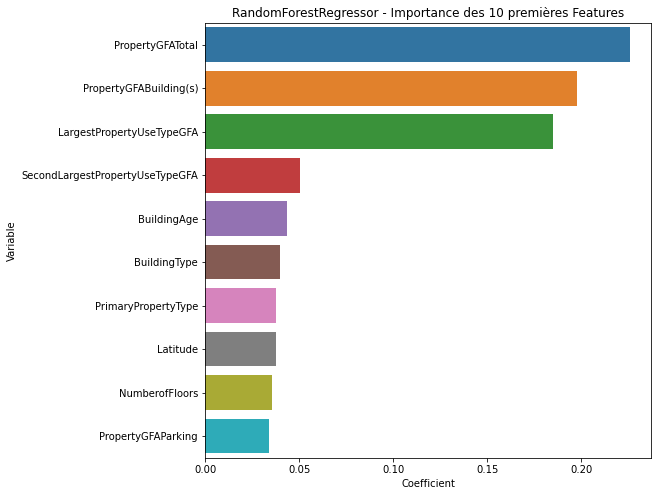

In [30]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 10 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(10),
            x = liste_coefs_rer['Coefficient'].head(10))
plt.show()

In [31]:
results = results.append(pd.DataFrame({
    'Modèle' : ['Random Forest Regressor'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(rfr_search.predict(X_test), y_test))]}),
              ignore_index=True)

In [32]:
results

,Modèle,Score_RMSE
0,Support Vector Machine,0.542123
1,Random Forest Regressor,0.562654


### 3.3. XG BOOST

In [33]:
%%time

parameters = {
    'n_estimators' : [100,200,500,1000]
}
xgb_grid = GridSearchCV(XGBRegressor(n_jobs=-1),
                        param_grid = parameters,
                        cv = 5,
                        verbose=5)
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=100, score=0.650, total=   0.4s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................... n_estimators=100, score=0.700, total=   0.4s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] .................... n_estimators=100, score=0.685, total=   0.4s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


[CV] .................... n_estimators=100, score=0.658, total=   0.4s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


[CV] .................... n_estimators=100, score=0.648, total=   0.4s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.641, total=   0.7s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.688, total=   0.7s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.679, total=   0.7s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.656, total=   0.7s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.643, total=   0.7s
[CV] n_estimators=500 ................................................
[CV] .................... n_estimators=500, score=0.639, total=   1.6s
[CV] n_estimators=500 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   23.1s finished


Wall time: 23.7 s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [34]:
xgb_grid.best_params_

{'n_estimators': 100}

In [35]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
results = results.append(pd.DataFrame({
    'Modèle' : ['XGBoost'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(xgb_grid.predict(X_test), y_test))]}),
              ignore_index=True)

In [37]:
results

,Modèle,Score_RMSE
0,Support Vector Machine,0.542123
1,Random Forest Regressor,0.562654
2,XGBoost,0.569362


### 3.4. ElasticNet

In [38]:
%%time

parameters = {'tol' : [0.1,0.01,0.001],
              "alpha": [0.0001, 0.001, 0.01, 0.1],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}#L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge


elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                      verbose=0
                     )

elastic_grid.fit(X_train, y_train)

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.54074999417816, tolerance: 190.4762827815957
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 459.26978861366564, tolerance: 187.80905346473594
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.4397095823026, tolerance: 185.7467644601995
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 459.444064176965, tolerance: 18.780905346473592
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.6237132535133, tolerance: 18.57467644601995
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 448.24377336137263, tolerance: 18.545554391742836
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 477.3296664253158, tolerance: 18.780905346473592
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.8183574712243, tolerance: 18.57467644601995
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 467.04783093460514, tolerance: 18.545554391742836
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn

Wall time: 6.42 s


C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.1644469455005, tolerance: 233.99249421921536
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001]},
             scoring='neg_mean_squared_error')

In [39]:
elastic_grid.best_params_

{'alpha': 0.1, 'l1_ratio': 0.0, 'tol': 0.1}

In [40]:
results = results.append(pd.DataFrame({
    'Modèle' : ['Elasticnet Regression'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(elastic_grid.predict(X_test), y_test))]}),
              ignore_index=True)

In [41]:
results

,Modèle,Score_RMSE
0,Support Vector Machine,0.542123
1,Random Forest Regressor,0.562654
2,XGBoost,0.569362
3,Elasticnet Regression,0.720325


# 4. Comparaison des modèles

### 4.1. Comparaison des RMSE

In [42]:
results

,Modèle,Score_RMSE
0,Support Vector Machine,0.542123
1,Random Forest Regressor,0.562654
2,XGBoost,0.569362
3,Elasticnet Regression,0.720325


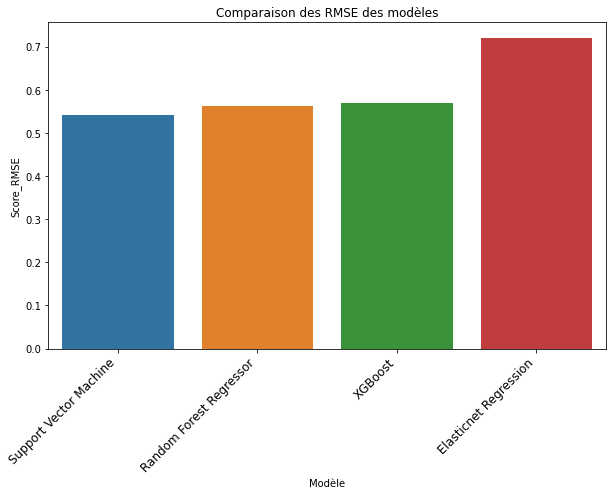

In [43]:
plt.figure(figsize=(10,6))
plt.title('Comparaison des RMSE des modèles')
chart = sns.barplot(x = results['Modèle'],
           y = results['Score_RMSE'])

chart.set_xticklabels(labels = results['Modèle'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
plt.show()

### 4.2. Comparaison des R2

In [44]:

nom_modeles = ['Elastic Net', 'Random Forest Regressor', 'SVM', 'XGBoost']

list_modeles = [elastic_grid.best_estimator_,
                 rfr_search.best_estimator_,
                 svm.best_estimator_,
                 xgb_grid.best_estimator_]


              
R2_score = pd.DataFrame(index = nom_modeles, columns = ['R2'])

for nom_modele, modele in zip(nom_modeles, list_modeles):
    
    R2_score.loc[nom_modele, 'R2'] = r2_score(y_test, modele.predict(X_test))

In [45]:
R2_score.sort_values(by='R2',ascending=False)

,R2
SVM,0.733768
Random Forest Regressor,0.713221
XGBoost,0.706343
Elastic Net,0.529975


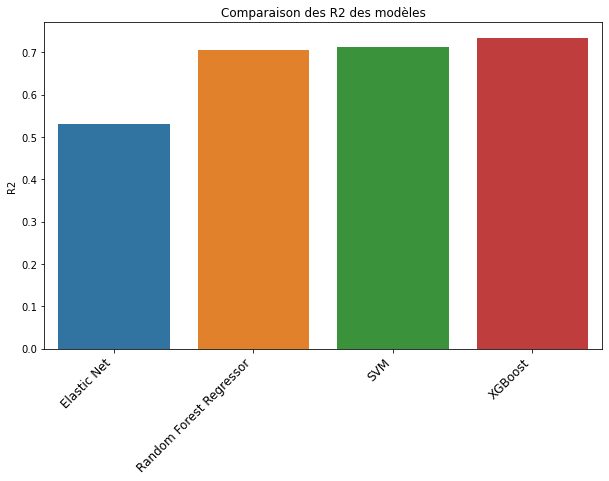

In [46]:
plt.figure(figsize=(10,6))
plt.title('Comparaison des R2 des modèles')
chart = sns.barplot(x = R2_score.index,
           y = R2_score['R2'].sort_values())

chart.set_xticklabels(labels = R2_score.index, 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
plt.show()

### 4.3. Comparaison des R2

In [47]:
i=0
for modele in list_modeles:
    print(nom_modeles[i], ': ')
    i+=1
    %timeit modele.predict(X_train)
    print('')
  

Elastic Net : 
1.7 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Random Forest Regressor : 
127 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

SVM : 
118 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

XGBoost : 
7.22 ms ± 41 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



In [48]:
nom_modeles = ['Elastic Net', 'Random Forest Regressor', 'SVM', 'XGBoost']


liste_modeles = list_modeles = [elastic_grid.best_estimator_,
                 rfr_search.best_estimator_,
                 svm.best_estimator_,
                 xgb_grid.best_estimator_]


Tableau_Scores = pd.DataFrame(index = nom_modeles, columns = ['RMSE', 'R2', 'Time'])

for nom_modele, modele in zip(nom_modeles, liste_modeles):
    Tableau_Scores.loc[nom_modele, 'RMSE'] = math.sqrt(mean_squared_error(y_test, modele.predict(X_test)))
    Tableau_Scores.loc[nom_modele, 'R2'] = r2_score(y_test, modele.predict(X_test))

In [49]:
time_list =[1.76, 217, 127, 7.35]

Tableau_Scores['Time']=time_list

Tableau_Scores


,RMSE,R2,Time
Elastic Net,0.720325,0.529975,1.76
Random Forest Regressor,0.562654,0.713221,217.00
SVM,0.542123,0.733768,127.00
XGBoost,0.569362,0.706343,7.35


In [50]:
Tableau_Scores.sort_values(by='Time')['Time'].index

Index(['Elastic Net', 'XGBoost', 'SVM', 'Random Forest Regressor'], dtype='object')

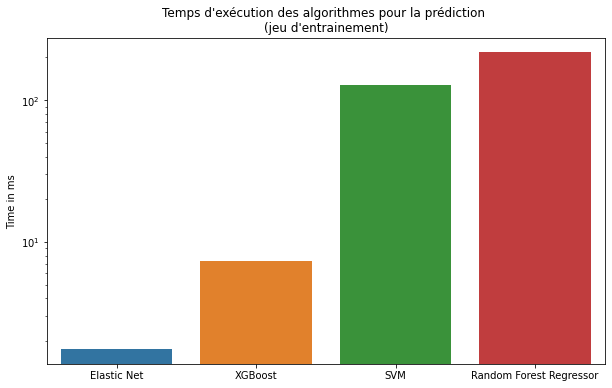

In [51]:
plt.figure(figsize=(10,6))
plt.title('Temps d\'exécution des algorithmes pour la prédiction \n(jeu d\'entrainement)')
sns.barplot(x=Tableau_Scores.sort_values(by='Time')['Time'].index,
            y=Tableau_Scores.sort_values(by='Time')['Time'])
           #y = [1.57, 110, 18, 5.6])
plt.ylabel('Time in ms')
ax = plt.gca()
ax.set_yscale('log')

# 5. Le modèle Emission : 
## Peut-on prédire les émissions en fonction de la consommation d'énergie ?

### Objectif : 

### 5.1. Préparation des données

####  Définition de nos X et y

In [52]:
y_em = data.copy()[{'TotalGHGEmissions','log-TotalGHGEmissions'}]

X_em = data.copy().drop(['TotalGHGEmissions', 'Log-SiteEnergyUseWN(kBtu)','log-TotalGHGEmissions'], axis=1)

#### Standard Scaler des variables numériques

In [53]:
standard_scaler(X_em)

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,LargestPropertyUseType,SecondLargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),BuildingAge
0,Multifamily LR (1-4),Residential,1.212985,DOWNTOWN,-0.303974,-0.198485,Residential,Retail,-0.069128,-0.098826,-0.324093,-0.333214,-0.280343,-0.357211,-0.035132,-0.101152,2.032469
1,Multifamily LR (1-4),Residential,-1.619262,DELRIDGE,-1.667002,-1.514531,Residential,Not Used,-0.069128,-0.098826,-0.284103,-0.333214,-0.233852,-0.173274,-0.438993,-0.418758,-1.195144
2,NonResidential,Office,1.212985,DOWNTOWN,-0.365093,-0.077714,Office,Not Used,-0.069128,0.401893,0.208820,0.776735,0.017954,0.435847,-0.438993,0.398524,1.851481
3,NonResidential,Office,1.212985,LAKE UNION,-0.059662,-0.296526,Office,Parking,-0.069128,-0.098826,1.226073,1.287774,1.052694,0.966792,1.441248,1.966562,0.614732
4,NonResidential,Office,-1.147221,GREATER DUWAMISH,-1.112236,1.381808,Office,Parking,-0.069128,-0.349186,-0.023292,0.583607,-0.195999,-0.133040,0.407806,0.094519,-1.225309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,Multifamily MR (5-9),Residential,-0.203138,NORTHEAST,0.818207,0.753396,Residential,Not Used,-0.069128,0.652252,-0.159465,-0.125527,-0.149061,0.078445,-0.438993,-0.241229,-1.406296
3226,Multifamily MR (5-9),Residential,-0.203138,NORTHEAST,0.654013,0.660724,Residential,Not Used,-0.069128,0.652252,2.624927,-0.333214,3.148177,3.421506,-0.438993,2.119244,-1.406296
3227,Multifamily MR (5-9),Residential,-0.675179,EAST,-0.467250,0.484206,Residential,Parking,-0.069128,0.401893,0.077423,0.048245,0.076047,0.172219,-0.117597,-0.293701,-1.406296
3228,NonResidential,Mixed Use Property,1.212985,LAKE UNION,0.013053,-0.141330,Health,Office,-0.069128,0.401893,2.841239,3.307865,2.345784,1.136093,3.773168,5.856414,-1.406296


####  Label encoding des données catégorielles

In [54]:
Label_Encoder(X_em)

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,LargestPropertyUseType,SecondLargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),BuildingAge
0,2,9,1.212985,3,-0.303974,-0.198485,8,10,-0.069128,-0.098826,-0.324093,-0.333214,-0.280343,-0.357211,-0.035132,-0.101152,2.032469
1,2,9,-1.619262,2,-1.667002,-1.514531,8,5,-0.069128,-0.098826,-0.284103,-0.333214,-0.233852,-0.173274,-0.438993,-0.418758,-1.195144
2,4,7,1.212985,3,-0.365093,-0.077714,5,5,-0.069128,0.401893,0.208820,0.776735,0.017954,0.435847,-0.438993,0.398524,1.851481
3,4,7,1.212985,6,-0.059662,-0.296526,5,8,-0.069128,-0.098826,1.226073,1.287774,1.052694,0.966792,1.441248,1.966562,0.614732
4,4,7,-1.147221,5,-1.112236,1.381808,5,8,-0.069128,-0.349186,-0.023292,0.583607,-0.195999,-0.133040,0.407806,0.094519,-1.225309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,3,9,-0.203138,9,0.818207,0.753396,8,5,-0.069128,0.652252,-0.159465,-0.125527,-0.149061,0.078445,-0.438993,-0.241229,-1.406296
3226,3,9,-0.203138,9,0.654013,0.660724,8,5,-0.069128,0.652252,2.624927,-0.333214,3.148177,3.421506,-0.438993,2.119244,-1.406296
3227,3,9,-0.675179,4,-0.467250,0.484206,8,8,-0.069128,0.401893,0.077423,0.048245,0.076047,0.172219,-0.117597,-0.293701,-1.406296
3228,4,6,1.212985,6,0.013053,-0.141330,3,6,-0.069128,0.401893,2.841239,3.307865,2.345784,1.136093,3.773168,5.856414,-1.406296


In [55]:
X_em.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'SiteEnergyUseWN(kBtu)', 'BuildingAge'],
      dtype='object')

#### Nous ne conservons que la variable Consommation d'énergie ('SiteEnergyUseWN(kBtu)')pour la définition de nos X

In [56]:
X_em.drop(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA','BuildingAge'], axis=1, inplace=True)

In [57]:
X_em.shape

(3230, 1)

#### Préparation de nos données d'entrainement et nos données de test

In [58]:
X_em_train, X_em_test, y_em_train, y_em_test = train_test_split(X_em, 
                                         y_em['log-TotalGHGEmissions'],  
                                         test_size = 0.3, 
                                         random_state = 42
                                        )

### Support Vector Regressor

In [59]:

%%time
parameters = {'gamma' : [ 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [ 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [ 0.1, 1, 10]} #parametre de régularisation

svm2 = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      #scoring = 'neg_mean_squared_error',
                      cv=5,
                   verbose=2
                     )

svm2.fit(X_em_train, y_em_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.1s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.1s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.1s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.1s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.1s
[CV] C=0.1, epsilon=0.01, gamma=0.01 .................................
[CV] .................. C=0.1, epsilon=0.01, gamma=0.01, total=   0.1s
[CV] C=0.1, epsilon=0.01, gamma=0.01 .................................
[CV] .................. C=0.1, epsilon=0.01, gamma=0.01, total=   0.1s
[CV] C=0.1, epsilon=0.01, gamma=0.01 .................................
[CV] .................. C=0.1, epsilon=0.01, gamma=0.01, total=   0.2s
[CV] C=0.1, epsilon=0.01, gamma=0.01 .................................
[CV] .

[CV] ..................... C=1, epsilon=0.01, gamma=0.1, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] .................... C=1, epsilon=0.1, gamma=0.001, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.01 ....................................
[CV] ..................... C=1, epsilon=0.1, gamma=0.01, total=   0.1s
[CV] C=1, epsilon=0.1, gamma=0.01 ....................................
[CV] .

[CV] ..................... C=10, epsilon=0.1, gamma=0.1, total=   0.2s
[CV] C=10, epsilon=0.1, gamma=0.1 ....................................
[CV] ..................... C=10, epsilon=0.1, gamma=0.1, total=   0.1s
[CV] C=10, epsilon=0.1, gamma=0.1 ....................................
[CV] ..................... C=10, epsilon=0.1, gamma=0.1, total=   0.2s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] ..................... C=10, epsilon=1, gamma=0.001, total=   0.1s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] ..................... C=10, epsilon=1, gamma=0.001, total=   0.0s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] ..................... C=10, epsilon=1, gamma=0.001, total=   0.0s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] ..................... C=10, epsilon=1, gamma=0.001, total=   0.1s
[CV] C=10, epsilon=1, gamma=0.001 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   14.8s finished


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1],
                         'gamma': [0.001, 0.01, 0.1]},
             verbose=2)

In [60]:
svm2.best_params_

{'C': 10, 'epsilon': 1, 'gamma': 0.1}

### Résultats émissions :

In [61]:
results2 = pd.DataFrame({})

In [62]:
results2 = results2.append(pd.DataFrame({
    'Modèle' : ['Support Vector Machine'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(svm2.predict(X_em_test), y_em_test))],
    'R2'  :  [r2_score(y_em_test, svm2.predict(X_em_test))]}),
              ignore_index=True)

In [63]:
results2

,Modèle,Score_RMSE,R2
0,Support Vector Machine,0.719872,0.745168


In [64]:
%timeit svm2.predict(X_em_train)

11 ms ± 56.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
results2['Time']= [11]
results2

,Modèle,Score_RMSE,R2,Time
0,Support Vector Machine,0.719872,0.745168,11


# 6. Conclusion